In [79]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image

In [104]:
n_power = 0.0
dm_mass = 1000.0 #GeV
step_size_cross_section = 2e-26 * pow(dm_mass,0.15)

list_param = ['omega_b','omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmeff']
list_fiducial = [0.02222, 0.1197,      0.69,  2.1955e-9, 0.9655, 0.06, 0]
list_step = [0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

Tcmb = 2.726

In [105]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': 2500,
    'lensing': 'yes',
    'omega_b': list_fiducial[0],
    'omega_dmeff': list_fiducial[1],
    'h': list_fiducial[2],
    'A_s' : list_fiducial[3],
    'n_s' : list_fiducial[4], 
    'tau_reio' : list_fiducial[5],
    'sigma_dmeff': list_fiducial[6],
    'm_dmeff': dm_mass,
    'omega_cdm' : 1.0e-10,
    'npow_dmeff': n_power
}

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.lensed_cl(2500)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']

In [106]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=2500):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.lensed_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [107]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmeff':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

<ipython-input-107-bdc1f727b3e0>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


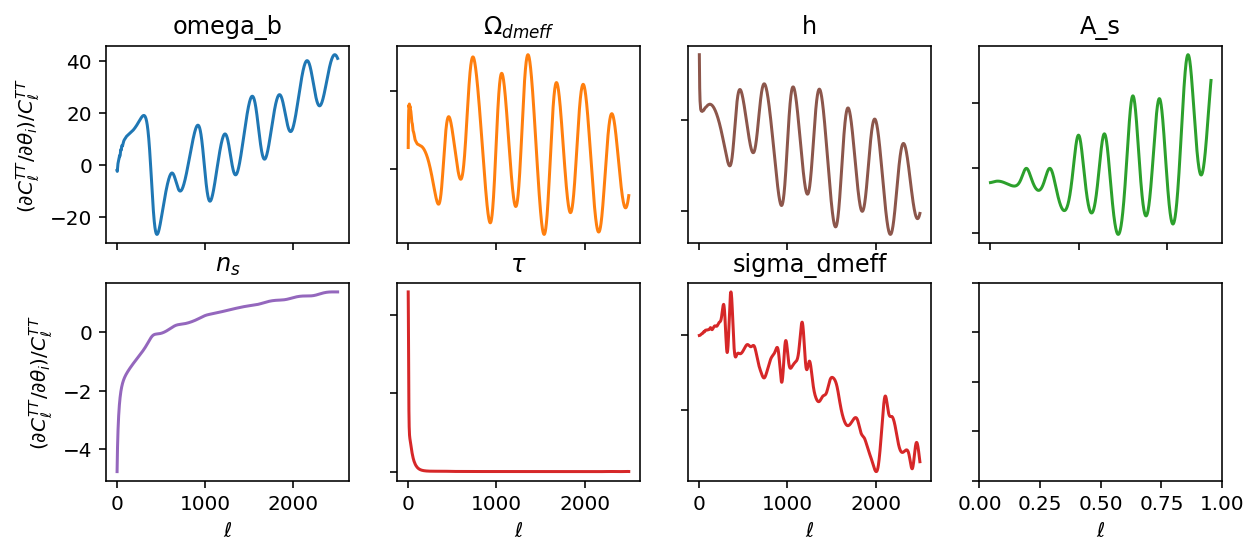

In [108]:
#Plotting Derivatives
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)
fig, axs = plt.subplots(2, 4, figsize=(10,4))

axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')

axs[0, 1].plot(dict_norm_der['omega_dmeff'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmeff}$')

axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')

axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')

axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')

axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')

axs[1, 2].plot(dict_norm_der['sigma_dmeff'], 'tab:red')
axs[1, 2].set_title('sigma_dmeff')

for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#fig.savefig("fisher_plots/derivative_C_l_TT_10GeV_n=2_S4.png")


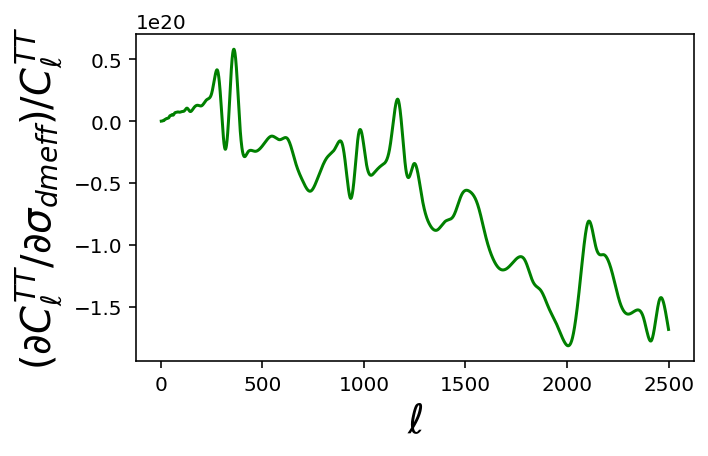

In [109]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(ell, dict_norm_der['sigma_dmeff'],'g-',label="sigma_dmeff")
plt.ylabel(r'$(\partial C_{\ell}^{TT} / \partial \sigma_{dmeff}) / C_{\ell}^{TT}$',size=20)
plt.xlabel(r'$\ell$',size=20)
plt.show()

In [110]:
#sT = (1. * (np.pi/60./180. ))/(1.0e6*Tcmb)
#sP = sT * np.sqrt(2.)
f_sky = 0.4
theta_fwhm = 1.5 * (np.pi/60./180.)

l_min = 2
l_max = 2500

from scipy.special import expit

'''N_TT = np.zeros(l_max+1, 'float64')
N_EE = np.zeros(l_max+1, 'float64')

for l in range(l_min , l_max+1):
            N_TT[l] = 0
            N_TT[l] += sT**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_TT[l] = 1/N_TT[l]
            N_EE[l] = 0
            N_EE[l] += sP**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_EE[l] = 1/N_EE[l]
N_TT[ell < l_min] = 1e100
N_TT[ell > l_max] = 1e100
N_EE[ell < l_min] = 1e100
N_EE[ell > l_max] = 1e100'''

"N_TT = np.zeros(l_max+1, 'float64')\nN_EE = np.zeros(l_max+1, 'float64')\n\nfor l in range(l_min , l_max+1):\n            N_TT[l] = 0\n            N_TT[l] += sT**-2 *                    np.exp(\n                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))\n            N_TT[l] = 1/N_TT[l]\n            N_EE[l] = 0\n            N_EE[l] += sP**-2 *                    np.exp(\n                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))\n            N_EE[l] = 1/N_EE[l]\nN_TT[ell < l_min] = 1e100\nN_TT[ell > l_max] = 1e100\nN_EE[ell < l_min] = 1e100\nN_EE[ell > l_max] = 1e100"

In [111]:
a = np.load('CMB_S4_noise.npy')

nl_tt = a[0]/((1.0e6*Tcmb)**2)
nl_ee = a[1]/((1.0e6*Tcmb)**2)
nl_kk = a[2]/((1.0e6*Tcmb)**2)

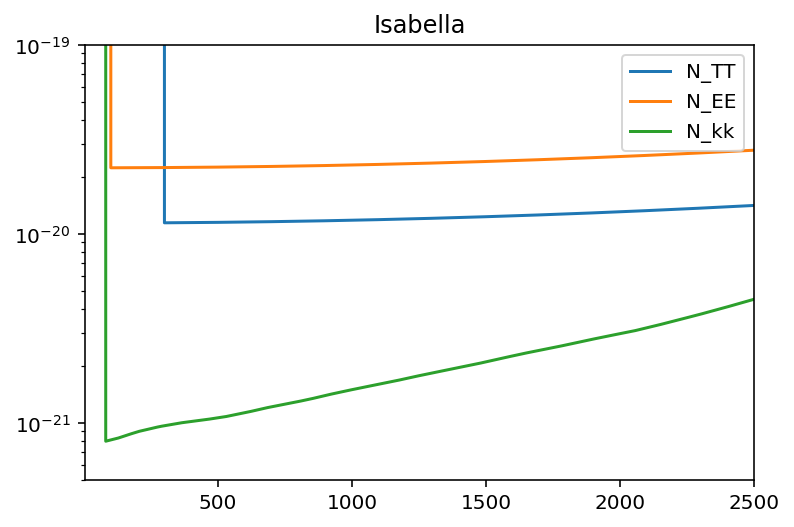

In [112]:
plt.plot(nl_tt, '-',label="N_TT")
plt.plot(nl_ee  , '-',label="N_EE")
plt.plot(nl_kk , '-',label="N_kk")

#plt.plot(N_EE*((1.0e6*Tcmb)**2) , '-',label="Polarization Noise")
#plt.plot(N_KK*((1.0e6*Tcmb)**2) , '--',label="Lensing Noise")
plt.yscale('log')
plt.ylim(5e-22,1e-19)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('Isabella')
plt.show()

In [113]:
'''import csv

with open('s4_noise_k.txt') as inf:
    reader = csv.reader(inf, delimiter=" ")
    second_col = [float(i) for i in list(zip(*reader))[3]]
    
N_kk = np.array(second_col)
Nlkk = N_kk[0:2501] /((1.0e6*Tcmb)**2)'''

'import csv\n\nwith open(\'s4_noise_k.txt\') as inf:\n    reader = csv.reader(inf, delimiter=" ")\n    second_col = [float(i) for i in list(zip(*reader))[3]]\n    \nN_kk = np.array(second_col)\nNlkk = N_kk[0:2501] /((1.0e6*Tcmb)**2)'

In [114]:
'''plt.plot(N_TT*((1.0e6*Tcmb)**2) , '-',label="Temperature Noise")
plt.plot(N_EE*((1.0e6*Tcmb)**2) , '-',label="Polarization Noise")
plt.plot(N_KK , '--',label="Lensing Noise")
plt.yscale('log')
plt.ylim(1e-15,1e4)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('Isabella')
plt.show()'''

'plt.plot(N_TT*((1.0e6*Tcmb)**2) , \'-\',label="Temperature Noise")\nplt.plot(N_EE*((1.0e6*Tcmb)**2) , \'-\',label="Polarization Noise")\nplt.plot(N_KK , \'--\',label="Lensing Noise")\nplt.yscale(\'log\')\nplt.ylim(1e-15,1e4)\nplt.xlim(2,2500)\nplt.legend(loc="upper right")\nplt.title(\'Isabella\')\nplt.show()'

We need:
 
$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$
[Wu et al. 2014](https://arxiv.org/abs/1402.4108)


Computing $C_l$ only using temperature power spectrum for planck baseline. 

$$ \mathbf{C}_{\ell} \equiv 
  \left( {\begin{array}{cc}
   C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)
 $$

Let :
$$   \mathbf{Q}^{i}_{nm} =\, \left( {C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \right)  =
  \left( {\begin{array}{cc}
    C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)^{-1}
   \left( {\begin{array}{cc}
    \frac{\partial C_{\ell}^{TT}}{\partial \theta_i } & \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } & 0 \\
   \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } &\frac{\partial C_{\ell}^{EE}}{\partial \theta_i } & 0 \\
    0 & 0 & \frac{\partial C_{\ell}^{\kappa\kappa}}{\partial \theta_i } \\
  \end{array} } \right)
$$
So that:
$$  F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left[  \mathbf{Q}_{i}  \mathbf{Q}_{j} \right]
$$

In [ ]:
MAT_d_cl = [ [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial),0]
            , [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial),0],
            [0,0,compute_d_cl(list_param_step, params, 'pp', fiducial)]
           ]

<ipython-input-107-bdc1f727b3e0>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [ ]:
MAT_cl = [
    [fiducial['tt'] + nl_tt, fiducial['te'], 0], 
    [fiducial['te'], fiducial['ee'] + nl_ee, 0],
    [0, 0, fiducial['pp'] + nl_kk] 
        ]

In [ ]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l]], [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l]]]
    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l]], [MAT_cl[1][0][l], MAT_cl[1][1][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 2500):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [ ]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)

In [ ]:
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

In [ ]:
#file = open("sigma_dmeff.txt", "w")
#print("sigma_dmeff","dm_mass [GeV]", sigma_ii*2.48 ,file=file)
#print(sigma_ii, dm_mass,file=file)

In [ ]:
#print(dm_mass, sigma_ii*2.48)

In [ ]:
import fishchips.util

cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);

#fig.savefig("fisher_plots/triagular_ellipses_10GeV_n=0_S4.png")

In [ ]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48)

In [ ]:
print(dat)

In [ ]:
1.8883599099943004e-25

In [ ]:
2.385149053902556e-25

In [ ]:
outF = open("fisher_data/S4_n=0/1000GeV.txt", "w")
for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()